<a href="https://colab.research.google.com/github/Shahahaha11/LION_DEN/blob/main/trial_MODEL_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name map


---


trial -> trying new variable

---


data_cleaning -> a separate file which ends with saving a pickle that you use in model.ipynb


---


model -> Main model with little extra code

---


model_testing -> Less code, optimized for testing

---



In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df_2 = pd.read_pickle("/content/drive/MyDrive/pickle_data/trial_2.pkl")


In [3]:
df_2.columns

Index(['latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'parkingSpaces', 'yearBuilt', 'latestPrice',
       'numPriceChanges', 'latest_saledate', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'Income', 'population', 'density',
       'MORTGAGE30US', 'MEDLISPRIPERSQUFEE12420'],
      dtype='object')

In [4]:
# Define X to exclude only the target initially
X = df_2.drop(columns=['latestPrice'])

# FIRST SPLIT
n_train = int(0.8 * len(df_2))
train = df_2.iloc[:n_train]
test  = df_2.iloc[n_train:]

X_train = train.drop(columns=['latestPrice'])
y_train = train['latestPrice']
X_test = test.drop(columns=['latestPrice'])
y_test = test['latestPrice']



In [6]:
# Capture the predictor columns actually used after dropping 'latest_saledate'
predictor_columns = X_train.drop(columns=['latest_saledate']).columns
############## LASSO REGULARIZATION ######################
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=['latest_saledate']))
X_test_scaled = scaler.transform(X_test.drop(columns=['latest_saledate']))

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Use the correct predictor columns for the coefficients
coef = pd.Series(lasso_cv.coef_, index=predictor_columns)
print("Lasso selected features:")
print(coef[coef != 0].sort_values(ascending=False))

Lasso selected features:
numOfBathrooms             168520.937357
livingAreaSqFt              90672.010241
avgSchoolRating             28270.007584
density                     14719.366070
hasSpa                       5922.393032
numOfElementarySchools       5321.176811
numOfWaterfrontFeatures      1301.100958
numOfHighSchools           -12675.703993
population                 -16691.571745
propertyTaxRate            -18568.872091
yearBuilt                  -19076.863716
hasAssociation             -49261.220405
dtype: float64


In [10]:
print(df_2[coef[coef!= 0].index.tolist()].columns)


Index(['propertyTaxRate', 'hasAssociation', 'hasSpa', 'yearBuilt',
       'numOfWaterfrontFeatures', 'livingAreaSqFt', 'numOfElementarySchools',
       'numOfHighSchools', 'avgSchoolRating', 'numOfBathrooms', 'population',
       'density'],
      dtype='object')


In [ ]:
"""
selected_features = [ 'Income', 'MORTGAGE30US', 'MEDLISPRIPERSQUFEE12420','propertyTaxRate', 'hasAssociation', 'hasSpa', 'yearBuilt', 'numOfWaterfrontFeatures', 'livingAreaSqFt', 'numOfElementarySchools',
       'numOfHighSchools', 'avgSchoolRating', 'numOfBathrooms', 'population',
       'density']
df_2 = df_2[selected_features]
df_2.shape
"""

(15020, 22)

In [ ]:
################ TRIAL SPLIT ############################
"""
n_test = int(0.2 * len(df_2))


test  = df_2.iloc[:n_test]
train = df_2.iloc[n_test:]

X_test = test.drop(columns=['latestPrice'])
y_test = test['latestPrice']
X_train = train.drop(columns=['latestPrice'])
y_train = train['latestPrice']

print(X_train.shape)
"""

"\nn_test = int(0.2 * len(df_2))\n\n\ntest  = df_2.iloc[:n_test]\ntrain = df_2.iloc[n_test:]\n\nX_test = test.drop(columns=['latestPrice_log'])\ny_test = test['latestPrice_log']\nX_train = train.drop(columns=['latestPrice_log'])\ny_train = train['latestPrice_log']\n\nprint(X_train.shape)\n"

In [11]:
pip install mgwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 21.5 MB/s eta 0:00:00


In [12]:
print(X_train.select_dtypes(include=['object']).columns)

Index([], dtype='object')


In [13]:
X_train.shape

(12016, 41)

In [14]:
# GWR using mgwr library: MAIN : output -> local_betas
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

coords = X_train[['latitude', 'longitude']].values
# dropping : garageSpaces and parkingSpaces are perfectly collinear (their correlation is 1 and their VIFs are infinite)
X_ = X_train.select_dtypes(include=['number']).drop(columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces', 'MORTGAGE30US', 'MEDLISPRIPERSQUFEE12420'],
    errors='ignore'
).values

y_ = y_train.values.reshape(-1, 1)
X_gwr = np.hstack([np.ones((X_.shape[0], 1)), X_])

# using a fixed band width
fixed_bw = 0.3

gwr_model = GWR(
    coords,       # (n, 2)
    y_,           # (n, 1)
    X_gwr,        # (n, p) [including intercept]
    bw=fixed_bw,
    kernel='gaussian',  # Gaussian kernel
    fixed=True,         # fixed distance bandwidth
    spherical=False
).fit()

local_betas = gwr_model.params  # shape (n, p)
print("Local betas shape:\n", local_betas.shape)


Local betas shape:
 (12016, 30)


In [18]:
############################################### Random Forest with Local Slopes #################################################
# MODEL 0 "USING local_betas" "no parameter tuning"

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Why did we remove from X_train?
# latitude & longitude -> used by GWR
# latest_saledate -> used for sorting, we have already dynamically incorporated time dependence using other variables
# parkingSpaces -> Perfect collinearity with Garage spaces

X_rf = X_train.select_dtypes(include=['number']).drop(
    columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces'],
    errors='ignore'
).values
print("X_rf shape:", X_rf.shape)

# local_betas are obtained from the GWR model; its shape is (n, p).
local_betas = gwr_model.params
print("local_betas shape:", local_betas.shape)

# local_slopes are defined by dropping the intercept column (first column) from local_betas.
# This gives us an array of shape (n, p-1).
local_slopes = local_betas[:, 1:]

X_aug = np.hstack([X_rf, local_slopes])
print("Augmented feature shape:", X_aug.shape)

y_array = y_.ravel()


n_total = X_aug.shape[0]
n_train = int(0.8 * n_total)

X_train_aug = X_aug[:n_train]
y_train_rf = y_array[:n_train]
X_valid_aug = X_aug[n_train:]
y_valid_rf = y_array[n_train:]

rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth =15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_samples = 0.8,
    max_features='sqrt',
    random_state=11,
    n_jobs=-1
)

rf.fit(X_train_aug, y_train_rf)
y_pred = rf.predict(X_valid_aug)

# Evaluation
r2 = r2_score(y_valid_rf, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid_rf, y_pred))

print("Random Forest Performance:")
print(f"  R^2:  {r2:.3f}")
print(f"  RMSE: {rmse:,.3f}")


X_rf shape: (12016, 31)
local_betas shape: (12016, 30)
Augmented feature shape: (12016, 60)
Random Forest Performance:
  R^2:  0.703
  RMSE: 230,109.118


In [19]:
train_dates = train['latest_saledate'].values
# Chronological split on the RF data (which comes from the training set)
n_rf_total = X_aug.shape[0]    # Should match len(train_dates)
n_rf_train = int(0.8 * n_rf_total)

X_train_aug = X_aug[:n_rf_train]
y_train_rf = y_array[:n_rf_train]
X_valid_aug = X_aug[n_rf_train:]
y_valid_rf = y_array[n_rf_train:]

rf_test_dates = train_dates[n_rf_train:]


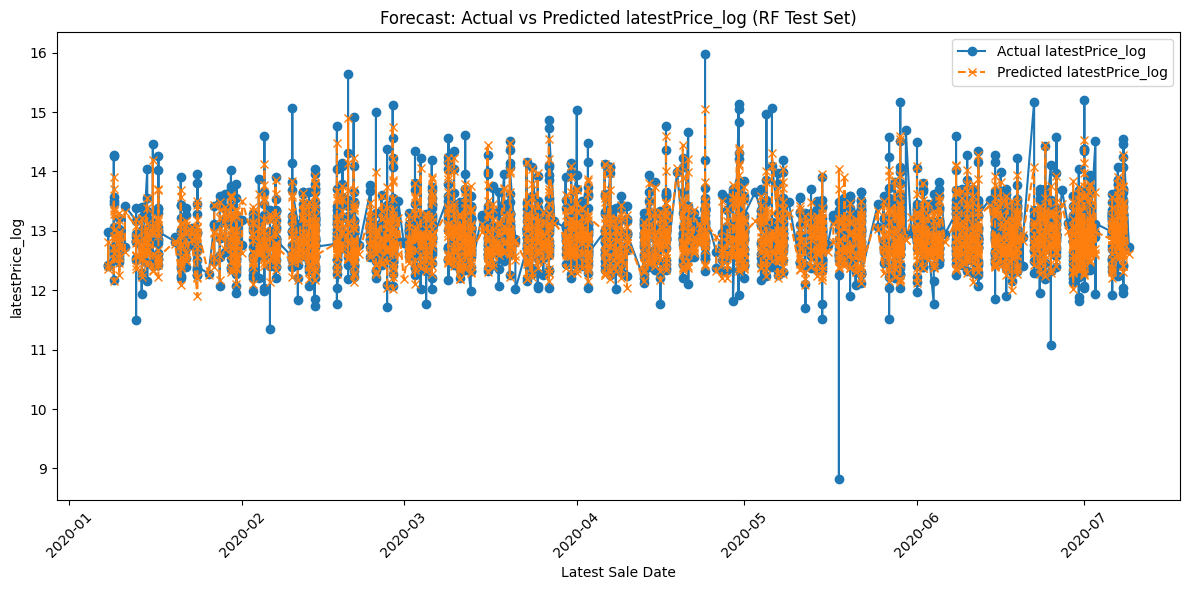

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(rf_test_dates, y_valid_rf, label='Actual latestPrice', marker='o', linestyle='-')
plt.plot(rf_test_dates, y_pred, label='Predicted latestPrice', marker='x', linestyle='--')
plt.xlabel('Latest Sale Date')
plt.ylabel('latestPrice')
plt.title('Forecast: Actual vs Predicted latestPrice (RF Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
########################################## MODEL PERFORMANCE EVALUATION ########################################

# Predict on the training and validation sets using the correct variables.
y_train_pred = rf.predict(X_train_aug)
y_valid_pred = rf.predict(X_valid_aug)

# Compute R² scores.
train_r2 = r2_score(y_train_rf, y_train_pred)
valid_r2 = r2_score(y_valid_rf, y_valid_pred)

# Compute RMSE scores.
train_rmse = np.sqrt(mean_squared_error(y_train_rf, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid_rf, y_valid_pred))

# Print training metrics.
print("Training Metrics:")
print(f"  R²:   {train_r2:.3f}")
print(f"  RMSE: {train_rmse:,.3f}")

# Print validation metrics.
print("\nValidation Metrics:")
print(f"  R²:   {valid_r2:.3f}")
print(f"  RMSE: {valid_rmse:,.3f}")


Training Metrics:
  R²:   0.802
  RMSE: 202,053.134

Validation Metrics:
  R²:   0.703
  RMSE: 230,109.118


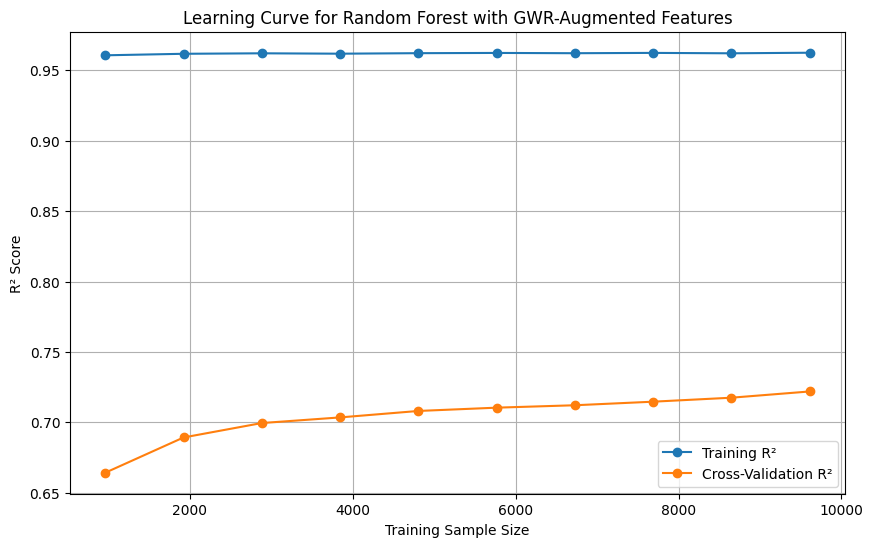

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# COMPUTE LEARNING CURVE
train_sizes, train_scores, valid_scores = learning_curve(
    estimator= rf,
    X=X_aug,
    y=y_array.ravel(),
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=11
)

# Calculate the mean scores across the folds
mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training R²')
plt.plot(train_sizes, mean_valid_scores, 'o-', label='Cross-Validation R²')
plt.xlabel('Training Sample Size')
plt.ylabel('R² Score')
plt.title('Learning Curve for Random Forest with GWR-Augmented Features')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_2.columns

Index(['latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'parkingSpaces', 'yearBuilt', 'latestPrice',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'numOfPhotos', 'numOfAccessibilityFeatures',
       'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'MORTGAGE30US',
       'MEDLISPRIPERSQUFEE12420'],
      dtype='object')

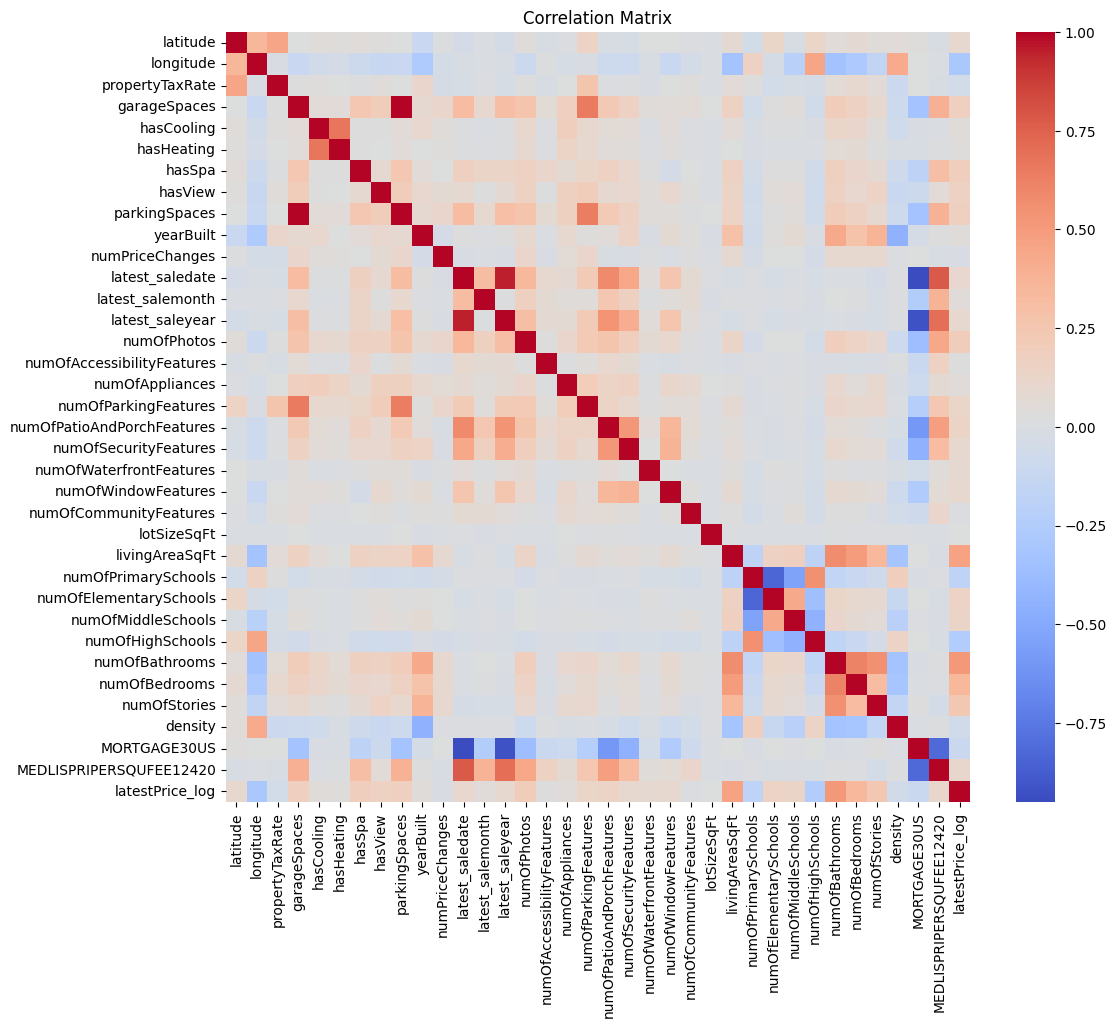

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_2.corr()

# Plot a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Define predictors and target variable (update 'latestPrice' as needed)
X = df_2.drop(columns=['latestPrice', 'latest_saledate'])
y = df_2['latestPrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Display feature importances
for i in indices:
    print(f"{X.columns[i]}: {importances[i]:.4f}")


livingAreaSqFt: 0.3896
avgSchoolRating: 0.0780
density: 0.0625
longitude: 0.0548
latitude: 0.0536
numOfBathrooms: 0.0462
lotSizeSqFt: 0.0431
numPriceChanges: 0.0370
population: 0.0296
avgSchoolSize: 0.0293
yearBuilt: 0.0280
hasAssociation: 0.0222
MORTGAGE30US: 0.0183
numOfPhotos: 0.0165
avgSchoolDistance: 0.0156
numOfAppliances: 0.0091
numOfBedrooms: 0.0079
latest_salemonth: 0.0075
MEDLISPRIPERSQUFEE12420: 0.0075
MedianStudentsPerTeacher: 0.0050
numOfParkingFeatures: 0.0045
numOfPatioAndPorchFeatures: 0.0039
propertyTaxRate: 0.0031
numOfElementarySchools: 0.0025
numOfSecurityFeatures: 0.0025
garageSpaces: 0.0024
latest_saleyear: 0.0023
numOfStories: 0.0023
numOfHighSchools: 0.0023
parkingSpaces: 0.0021
numOfWindowFeatures: 0.0017
hasView: 0.0016
hasCooling: 0.0015
numOfPrimarySchools: 0.0014
hasSpa: 0.0013
hasHeating: 0.0012
numOfWaterfrontFeatures: 0.0009
hasGarage: 0.0008
numOfCommunityFeatures: 0.0003
numOfMiddleSchools: 0.0003
numOfAccessibilityFeatures: 0.0001
